In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
model_dir = '/content/gdrive/My Drive/Winter 2020/DL/Project 2/models/'
!cp /content/gdrive/My\ Drive/Winter\ 2020/DL/Project\ 2/data/*.zip .
!unzip /content/sudoku.zip
!mkdir /content/test
!unzip /content/sudoku_test.zip -d /content/test
!mv /content/test/sudoku.csv /content/sudoku_test.csv

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Archive:  /content/sudoku.zip
replace sudoku.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
mkdir: cannot create directory ‘/content/test’: File exists
Archive:  /content/sudoku_test.zip
  inflating: /content/test/sudoku.csv  


In [2]:
!git clone https://github.com/cloughurd/drl-sudoku.git
!mv drl-sudoku/rl/* .

Cloning into 'drl-sudoku'...
remote: Enumerating objects: 282, done.
remote: Counting objects: 100% (282/282), done.
remote: Compressing objects: 100% (220/220), done.
remote: Total 282 (delta 175), reused 120 (delta 54), pack-reused 0
Receiving objects: 100% (282/282), 423.86 KiB | 1.59 MiB/s, done.
Resolving deltas: 100% (175/175), done.


In [0]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import json

assert torch.cuda.is_available()
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose',color_scheme='LightBg', tb_offset = 1)

from env.fullgrid import GridEnv
from helpers import prepare_batch, learn_dqn, get_action_dqn
from qnetwork import QNetwork

In [13]:
def dqn_main(num_epochs=10000):
    # Hyper parameters
    lr = 1e-3
    start_training = 1000
    gamma = 0.99
    batch_size = 512
    epsilon = 1
    epsilon_decay = .9995
    target_update = 1000
    learn_frequency = 2

    # Init environment
    action_size = 9*81
    env = GridEnv('/content/sudoku.csv', max_len=100000, weight=True)

    # Init networks
    q_network = QNetwork(18, action_size).cuda()
    target_network = QNetwork(18, action_size).cuda()
    target_network.load_state_dict(q_network.state_dict())

    # Init optimizer
    optim = torch.optim.Adam(q_network.parameters(), lr=lr)

    # Init replay buffer
    memory = []

    total_learnings = 0

    # Begin main loop
    save_freq = 2500
    results_dqn = []
    losses = []
    reward_curves = {}
    global_step = 0
    loop = tqdm(total=num_epochs, position=0, leave=False)
    for epoch in range(num_epochs):
        # New puzzle
        state, goal = env.reset()
        done = False
        cum_reward = 0  # Track cumulative reward per episode
        rewards = []
        pos_count = 0

        # Begin episode
        while not done and abs(cum_reward) < 40:
            # Select e-greedy action
            action, epsilon = get_action_dqn(q_network, state, epsilon, epsilon_decay)

            # Take step
            next_state, reward, done = env.act(state, action, goal)
            # env.render()

            # Store step in replay buffer
            memory.append((state, action, next_state, reward, done))
            if len(memory) > 5000:
              memory = memory[1000:]

            if reward > 0:
              pos_count += 1
            cum_reward += reward
            rewards.append(reward)
            global_step += 1  # Increment total steps
            state = next_state  # Set current state

        # If time to train
        if global_step > start_training:
            total_learnings += 1

            # Sample batch
            batch = prepare_batch(memory, batch_size)

            # Train
            loss = learn_dqn(batch, optim, q_network, target_network, gamma, global_step, target_update)
            losses.append((global_step, loss))

        # Print results at end of episode
        results_dqn.append(cum_reward)
        reward_curves[epoch] = rewards
        loop.update(1)
        loop.set_description('Episodes: {} Reward: {} Epsilon: {:.4f} Positive Reward Count: {}'.format(epoch, cum_reward, epsilon, pos_count))
        
        if (epoch+1) % save_freq == 0:
            torch.save(q_network.state_dict(), model_dir + f'rl-w-{epoch}.mod')
            json.dump({'rewards': reward_curves, 'loss': losses},
                      open(model_dir + f'rl-w-results-{epoch}.json', 'w'))

    print(total_learnings)
    return results_dqn

results_dqn = dqn_main()

Episodes: 2721 Reward: -40 Epsilon: 0.0000 Positive Reward Count: 4:  27%|██▋       | 2722/10000 [1:23:42<3:59:05,  1.97s/it]

KeyboardInterrupt: ignored

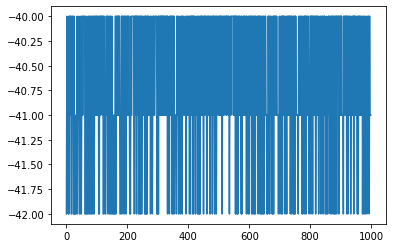

In [11]:
plt.plot(results_dqn)
plt.show()